In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d shubhamgoel27/dermnet

100% 1.72G/1.72G [00:46<00:00, 53.5MB/s]
100% 1.72G/1.72G [00:47<00:00, 39.2MB/s]


In [5]:
! unzip -q /content/dermnet.zip

In [6]:
!mkdir skin
!mkdir skin/train
!mkdir skin/test

In [7]:
!zip -r /content/Eczema-train.zip /content/train/Eczema
!zip -r /content/Eczema-test.zip /content/test/Eczema
!zip -r /content/Psoriasis-train.zip /content/train/Psoriasis
!zip -r /content/Psoriasis-test.zip /content/test/Psoriasis

  adding: content/train/Eczema/ (stored 0%)
  adding: content/train/Eczema/eczema-foot-9.jpg (deflated 0%)
  adding: content/train/Eczema/eczema-chronic-30.jpg (deflated 0%)
  adding: content/train/Eczema/eczema-subacute-52.jpg (deflated 0%)
  adding: content/train/Eczema/eczema-fingertips-130.jpg (deflated 1%)
  adding: content/train/Eczema/prurigo-nodularis-49.jpg (deflated 1%)
  adding: content/train/Eczema/keratolysis-exfoliativa-46.jpg (deflated 1%)
  adding: content/train/Eczema/eczema-nummular-97.jpg (deflated 0%)
  adding: content/train/Eczema/eczema-subacute-88.jpg (deflated 0%)
  adding: content/train/Eczema/lichen-simplex-chronicus-16.jpg (deflated 0%)
  adding: content/train/Eczema/eczema-asteatotic-7.jpg (deflated 0%)
  adding: content/train/Eczema/eczema-trunk-generalized-23.jpg (deflated 0%)
  adding: content/train/Eczema/heels-dry-cracked-1.jpg (deflated 0%)
  adding: content/train/Eczema/eczema-lids-14.jpg (deflated 0%)
  adding: content/train/Eczema/eczema-subacute-70

In [8]:
!cp '/content/Eczema-test.zip' '/content/skin/test'
!cp '/content/Psoriasis-test.zip' '/content/skin/test'
!cp '/content/Psoriasis-train.zip' '/content/skin/train'
!cp '/content/Eczema-train.zip' '/content/skin/train'

In [9]:
!unzip -q /content/skin/test/Eczema-test.zip
!unzip -q /content/skin/test/Psoriasis-test.zip
!unzip -q /content/skin/train/Eczema-train.zip
!unzip -q /content/skin/train/Psoriasis-train.zip

In [10]:
BATCH_SIZE = 64
IMAGE_SIZE = 300
train_path = "/content/content/train"
test_path = "/content/content/test"

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def train_val_generators(TRAINING_DIR, VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE):
  train_datagen = ImageDataGenerator(rescale=(1./255))

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE))

  test_datagen = ImageDataGenerator(rescale=1./255)

  
  test_generator = test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE))
  
  return train_generator, test_generator

In [12]:
train_generator,test_generator=train_val_generators(train_path, test_path,IMAGE_SIZE,BATCH_SIZE)

Found 2640 images belonging to 2 classes.
Found 661 images belonging to 2 classes.


In [13]:
train_generator.image_shape

(300, 300, 3)

# VGG-16

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise, RandomFlip, RandomZoom, Flatten, Dropout
from keras.applications.vgg16 import VGG16

vgg = VGG16(weights="imagenet", include_top=False, input_shape=(112, 112, 3), pooling='avg')
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation="sigmoid"))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics='accuracy')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [ ]:
history1 = model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[callback])

Epoch 1/5
42/42 [==============================] - 31s 570ms/step - loss: 0.6281 - accuracy: 0.6527 - val_loss: 0.6207 - val_accuracy: 0.6672
Epoch 2/5
42/42 [==============================] - 22s 521ms/step - loss: 0.5592 - accuracy: 0.7057 - val_loss: 0.6000 - val_accuracy: 0.6899
Epoch 3/5
42/42 [==============================] - 23s 544ms/step - loss: 0.5184 - accuracy: 0.7333 - val_loss: 0.5494 - val_accuracy: 0.7201
Epoch 4/5
42/42 [==============================] - 23s 539ms/step - loss: 0.4541 - accuracy: 0.7902 - val_loss: 0.5478 - val_accuracy: 0.7262
Epoch 5/5
42/42 [==============================] - 22s 519ms/step - loss: 0.4037 - accuracy: 0.8152 - val_loss: 0.5203 - val_accuracy: 0.7504


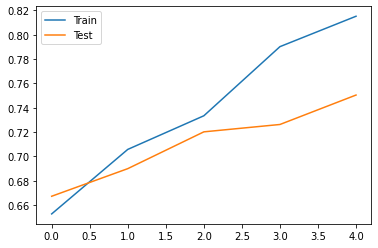

In [ ]:
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Test')
plt.legend()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise, RandomFlip, RandomZoom, Flatten, Dropout, RandomRotation
from keras.applications.vgg16 import VGG16

vgg = VGG16(weights="imagenet", include_top=False, pooling='avg')
model = Sequential()
# Add preproccesing layers
model.add(RandomZoom(0.5, 0.5, input_shape=(112, 112, 3)))
model.add(vgg)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation="softmax"))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics='accuracy')

In [ ]:
history2 = model.fit(train_generator, batch_size=1024, epochs=15, validation_data=test_generator, callbacks=[callback])

Epoch 1/15
42/42 [==============================] - 24s 530ms/step - loss: 0.6524 - accuracy: 0.6091 - val_loss: 0.6432 - val_accuracy: 0.6520
Epoch 2/15
42/42 [==============================] - 22s 528ms/step - loss: 0.6139 - accuracy: 0.6667 - val_loss: 0.5932 - val_accuracy: 0.6959
Epoch 3/15
42/42 [==============================] - 23s 536ms/step - loss: 0.5902 - accuracy: 0.6803 - val_loss: 0.5705 - val_accuracy: 0.6899
Epoch 4/15
42/42 [==============================] - 22s 517ms/step - loss: 0.5691 - accuracy: 0.6902 - val_loss: 0.5940 - val_accuracy: 0.6672
Epoch 5/15
42/42 [==============================] - 22s 518ms/step - loss: 0.5373 - accuracy: 0.7220 - val_loss: 0.6127 - val_accuracy: 0.6793
Epoch 6/15
42/42 [==============================] - 22s 519ms/step - loss: 0.5213 - accuracy: 0.7326 - val_loss: 0.5388 - val_accuracy: 0.7292
Epoch 7/15
42/42 [==============================] - 22s 516ms/step - loss: 0.4950 - accuracy: 0.7564 - val_loss: 0.5394 - val_accuracy: 0.7292

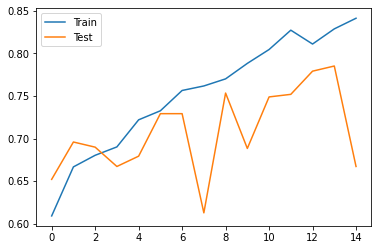

In [ ]:
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Test')
plt.legend()

# Inception-V3

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise, RandomFlip, RandomZoom, Flatten, Dropout, RandomRotation
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
model = Sequential()
model.add(RandomZoom(0.5, 0.5))
model.add(inception)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

87924736/87910968 [==============================] - 1s 0us/step


In [15]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics='accuracy')

In [16]:
history3 = model.fit(train_generator, epochs=25, validation_data=test_generator)

Epoch 1/25
42/42 [==============================] - 66s 1s/step - loss: 0.9251 - accuracy: 0.5701 - val_loss: 0.6993 - val_accuracy: 0.6263
Epoch 2/25
42/42 [==============================] - 42s 999ms/step - loss: 0.6317 - accuracy: 0.6508 - val_loss: 0.6487 - val_accuracy: 0.6641
Epoch 3/25
42/42 [==============================] - 42s 1s/step - loss: 0.5719 - accuracy: 0.7095 - val_loss: 0.5404 - val_accuracy: 0.7126
Epoch 4/25
42/42 [==============================] - 42s 997ms/step - loss: 0.4991 - accuracy: 0.7496 - val_loss: 0.5547 - val_accuracy: 0.7443
Epoch 5/25
42/42 [==============================] - 42s 1000ms/step - loss: 0.4263 - accuracy: 0.8098 - val_loss: 0.5191 - val_accuracy: 0.7640
Epoch 6/25
42/42 [==============================] - 42s 1s/step - loss: 0.3534 - accuracy: 0.8455 - val_loss: 0.5949 - val_accuracy: 0.7398
Epoch 7/25
42/42 [==============================] - 42s 999ms/step - loss: 0.3325 - accuracy: 0.8549 - val_loss: 0.5883 - val_accuracy: 0.7579
Epoch 8

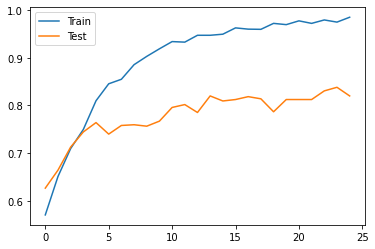

In [17]:
plt.plot(history3.history['accuracy'], label='Train')
plt.plot(history3.history['val_accuracy'], label='Test')
plt.legend()

In [23]:
model.evaluate(test_generator)

11/11 [==============================] - 5s 446ms/step - loss: 1.1008 - accuracy: 0.8200


[1.100838541984558, 0.8199697136878967]

**Import New Data**

In [18]:
! unzip -q /content/Data.zip

In [19]:
  test = '/content/data/Test'
  test_gen = ImageDataGenerator(rescale=(1./255))

  test = test_gen.flow_from_directory(directory=test,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 200 images belonging to 2 classes.


In [20]:
model.evaluate(test)

4/4 [==============================] - 2s 517ms/step - loss: 2.2951 - accuracy: 0.6500


[2.2950632572174072, 0.6499999761581421]

In [43]:
test.classes[0]

0

Prediction is : 0
Real Class is : 0


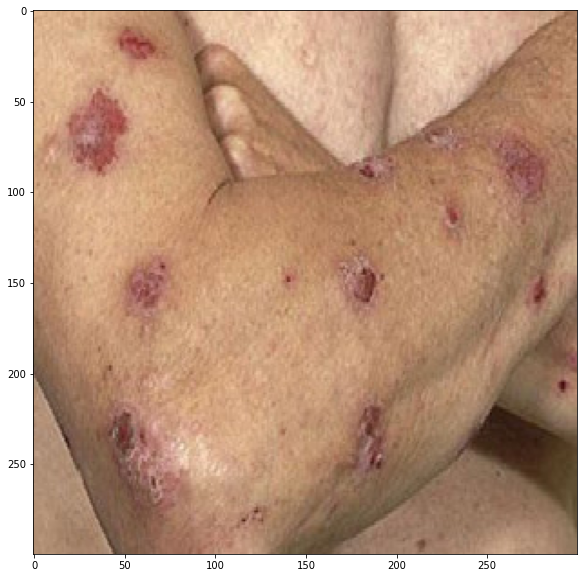

In [51]:
# print(test[0][0][1].shape)
pred = model.predict(test)
plt.figure(figsize=(15,10))
i = 0  
pre = np.argmax(pred[i])
print('Prediction is :', pre)
print('Real Class is :', test.classes[i])
plt.imshow(test[0][0][i])


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise, RandomFlip, RandomZoom, Flatten, Dropout, RandomRotation
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
model = Sequential()
# model.add(RandomZoom(0.5, 0.5))
model.add(inception)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics='accuracy')

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=test_generator)

Epoch 1/20
42/42 [==============================] - 58s 1s/step - loss: 0.8195 - accuracy: 0.5932 - val_loss: 0.7462 - val_accuracy: 0.5189
Epoch 2/20
42/42 [==============================] - 43s 1s/step - loss: 0.5134 - accuracy: 0.7492 - val_loss: 0.7887 - val_accuracy: 0.5779
Epoch 3/20
42/42 [==============================] - 44s 1s/step - loss: 0.3087 - accuracy: 0.8614 - val_loss: 0.7507 - val_accuracy: 0.6732
Epoch 4/20
42/42 [==============================] - 43s 1s/step - loss: 0.1404 - accuracy: 0.9470 - val_loss: 0.8555 - val_accuracy: 0.7458
Epoch 5/20
42/42 [==============================] - 43s 1s/step - loss: 0.0816 - accuracy: 0.9678 - val_loss: 0.8555 - val_accuracy: 0.7625
Epoch 6/20
42/42 [==============================] - 43s 1s/step - loss: 0.0485 - accuracy: 0.9845 - val_loss: 1.0420 - val_accuracy: 0.7595
Epoch 7/20
42/42 [==============================] - 43s 1s/step - loss: 0.0547 - accuracy: 0.9814 - val_loss: 1.0126 - val_accuracy: 0.7610
Epoch 8/20
42/42 [==

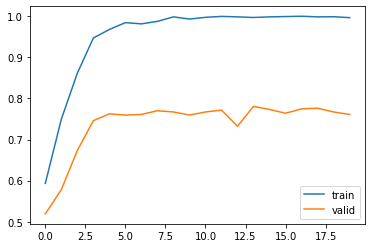

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()

In [ ]:
# Data Augmentation Example
aug = Sequential([
    RandomZoom(0.5, 0.5),
    RandomFlip()
])

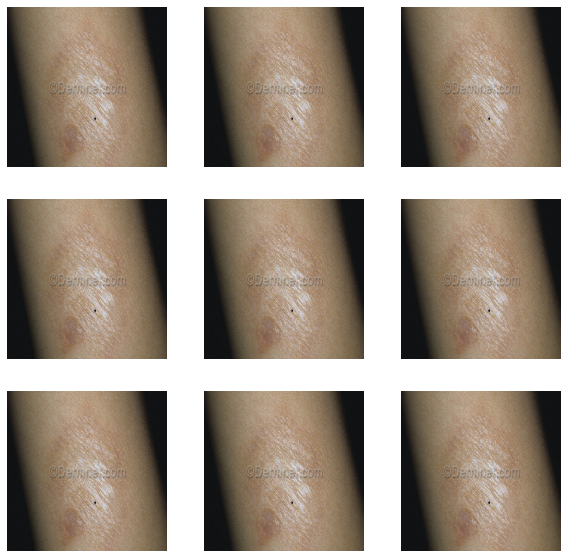

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = aug(train_generator[0][0][5])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)
  plt.axis("off")

# EfficientNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise, RandomFlip, RandomZoom, Flatten, Dropout, BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.applications.efficientnet import EfficientNetB6
IMAGE_SIZE= (300, 300)
IMAGE_DIM= IMAGE_SIZE+(3,)
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
url= 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

base_model= hub.KerasLayer(url, input_shape=IMAGE_DIM, trainable=False)

In [ ]:
model= Sequential([
    #RandomZoom(0.5, 0.5),
    base_model,
    Dense(512, 'relu'),
    Dense(256, 'relu'),
    Dense(2, 'softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics='accuracy')

In [ ]:
history = model.fit(train_generator, batch_size=512, epochs=20, validation_data=test_generator)

Epoch 1/20
42/42 [==============================] - 27s 595ms/step - loss: 0.6655 - accuracy: 0.6019 - val_loss: 0.6476 - val_accuracy: 0.6415
Epoch 2/20
42/42 [==============================] - 24s 573ms/step - loss: 0.6240 - accuracy: 0.6886 - val_loss: 0.6261 - val_accuracy: 0.6657
Epoch 3/20
42/42 [==============================] - 24s 562ms/step - loss: 0.6004 - accuracy: 0.7011 - val_loss: 0.6136 - val_accuracy: 0.6762
Epoch 4/20
42/42 [==============================] - 24s 568ms/step - loss: 0.5836 - accuracy: 0.7038 - val_loss: 0.6055 - val_accuracy: 0.6793
Epoch 5/20
42/42 [==============================] - 24s 581ms/step - loss: 0.5708 - accuracy: 0.7076 - val_loss: 0.5990 - val_accuracy: 0.6793
Epoch 6/20
42/42 [==============================] - 24s 579ms/step - loss: 0.5600 - accuracy: 0.7170 - val_loss: 0.5956 - val_accuracy: 0.6853
Epoch 7/20
42/42 [==============================] - 24s 569ms/step - loss: 0.5503 - accuracy: 0.7239 - val_loss: 0.5906 - val_accuracy: 0.6853

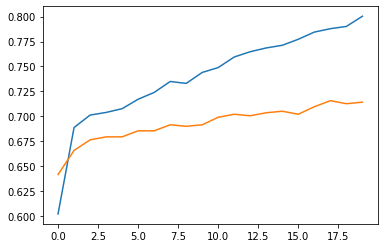

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

In [ ]:
model= Sequential([
    RandomZoom(0.5, 0.5),
    base_model,
    Dense(512, 'relu'),
    Dense(256, 'relu'),
    Dense(2, 'softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics='accuracy')

In [ ]:
history = model.fit(train_generator, batch_size=512, epochs=20, validation_data=test_generator)

Epoch 1/20
42/42 [==============================] - 86s 606ms/step - loss: 0.6830 - accuracy: 0.5598 - val_loss: 0.6664 - val_accuracy: 0.6142
Epoch 2/20
42/42 [==============================] - 24s 577ms/step - loss: 0.6552 - accuracy: 0.6326 - val_loss: 0.6451 - val_accuracy: 0.6248
Epoch 3/20
42/42 [==============================] - 25s 589ms/step - loss: 0.6422 - accuracy: 0.6402 - val_loss: 0.6312 - val_accuracy: 0.6445
Epoch 4/20
42/42 [==============================] - 25s 590ms/step - loss: 0.6287 - accuracy: 0.6633 - val_loss: 0.6220 - val_accuracy: 0.6475
Epoch 5/20
42/42 [==============================] - 24s 582ms/step - loss: 0.6174 - accuracy: 0.6633 - val_loss: 0.6134 - val_accuracy: 0.6626
Epoch 6/20
42/42 [==============================] - 25s 586ms/step - loss: 0.6076 - accuracy: 0.6689 - val_loss: 0.6112 - val_accuracy: 0.6505
Epoch 7/20
42/42 [==============================] - 24s 582ms/step - loss: 0.6061 - accuracy: 0.6708 - val_loss: 0.6070 - val_accuracy: 0.6702

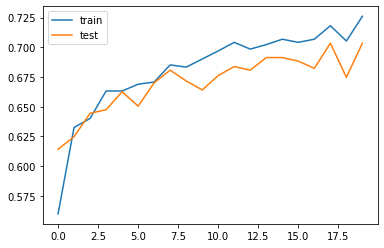

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()